# Feature selection for regression

The goal of feature selection is to select those features that are relevant and contribute the most so that we get better accuracy when using the model to make predictions

When we have a very large dataset consiting of many features then feature selection can be of help:
- `Reduces the curse of dimensionality:` Removing the features that are correlated and do not contribute to the model,we can work with more manageble dataset
- `Minimizing the cost of computation:` Less features, less computation
- `Helps in model learning:` We provide only the best features to the model
- `Achieves good accuracy`

**Techniques**

We are focused on two feature selection methods:
- Correelation
- mutual information
- Variance

**Sources**
- [sklearn-feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [model-based feature selection](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py)

In [1]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import feature_selection
from sklearn.datasets import load_diabetes

### Diabetes

**Dataset description:**

- age age in years
- sex
- bmi body mass index
- bp average blood pressure
- s1 tc, total serum cholesterol
- s2 ldl, low-density lipoproteins
- s3 hdl, high-density lipoproteins
- s4 tch, total cholesterol / HDL
- s5 ltg, possibly log of serum triglycerides level
- s6 glu, blood sugar level
- Target, Column 11 is a quantitative measure of disease progression one year after baseline

In [3]:
diabetes = load_diabetes()

In [4]:
X = diabetes['data']
Y = diabetes['target']
cols = diabetes['feature_names']

df = pd.DataFrame(X, columns=cols)
df['disease progression'] = Y

### Check correlation between features

In the plot below, we can quickly check if there are any correlated independent features. When our dataset is small as in this case, we can manually observe features that exhibit strong correlation with other features. If our dataset consist of many features, we will need an automated way of discarding correlated features. The automated process is described further down this notebook

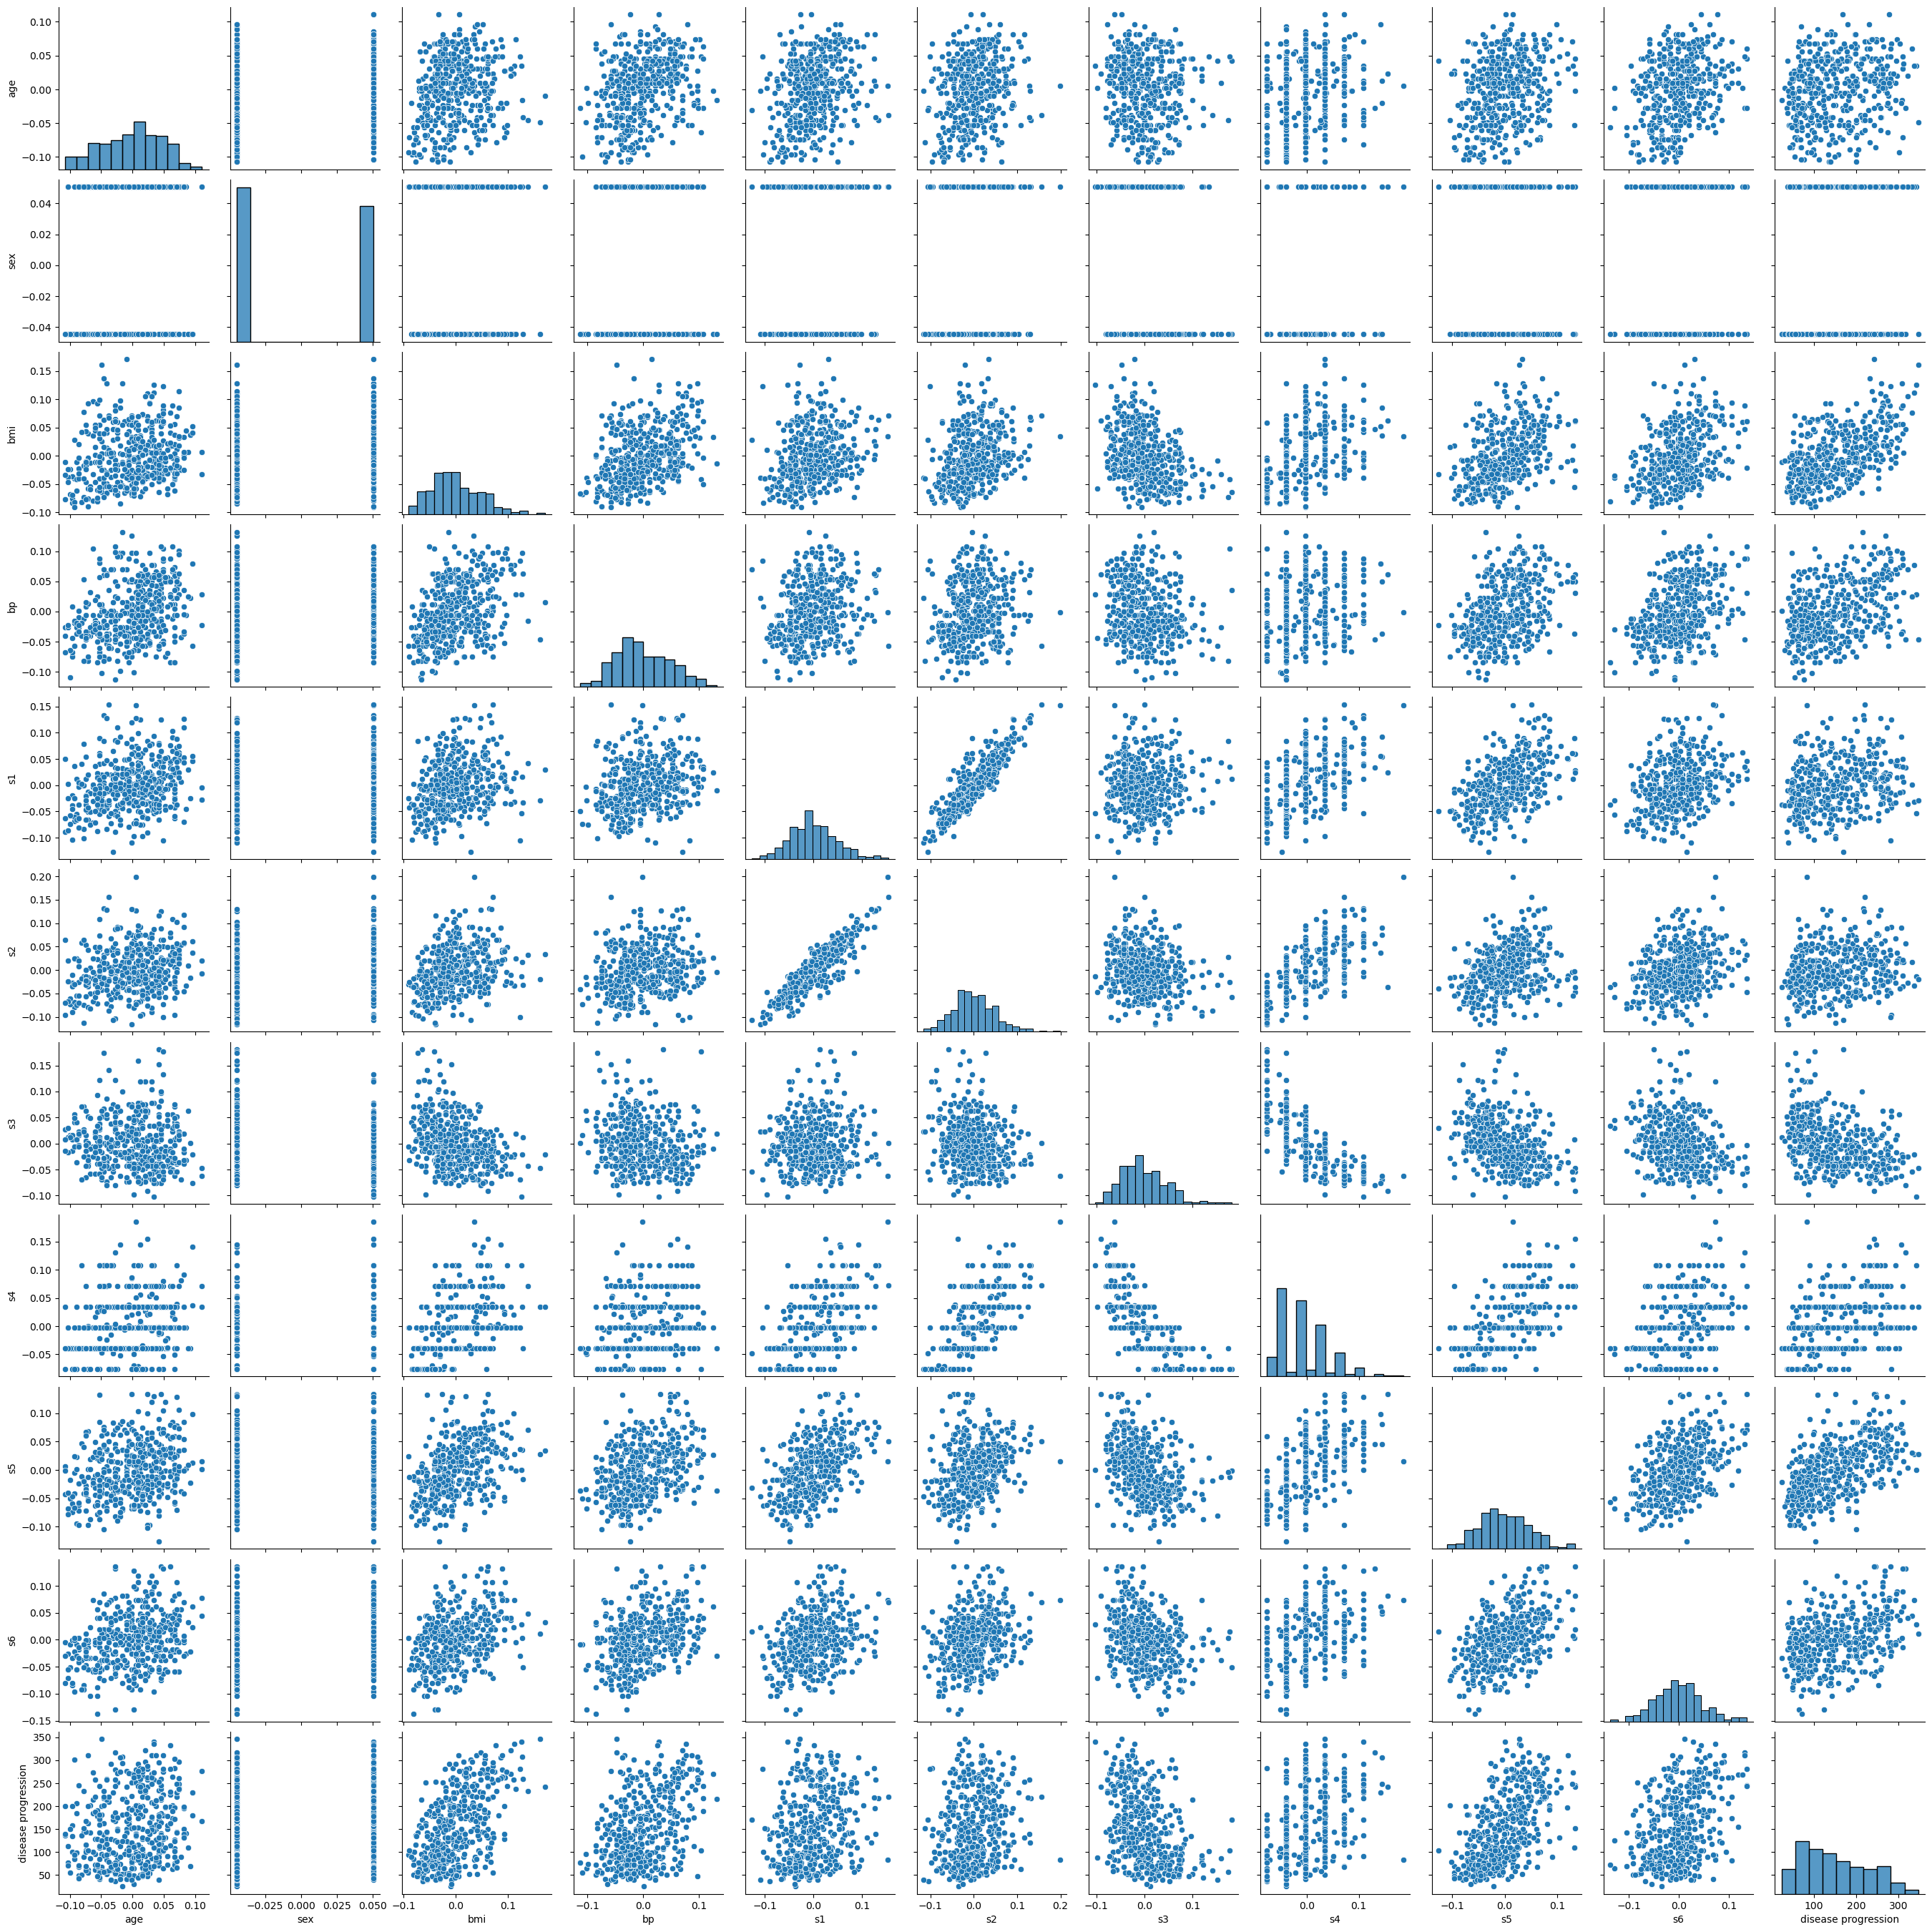

In [9]:
sns.pairplot(df)

In [26]:
corr_mat = df.corr()
corr_mat

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease progression
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680,0.586450
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430,0.441482
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212,0.430453
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669,0.565883
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000,0.382483


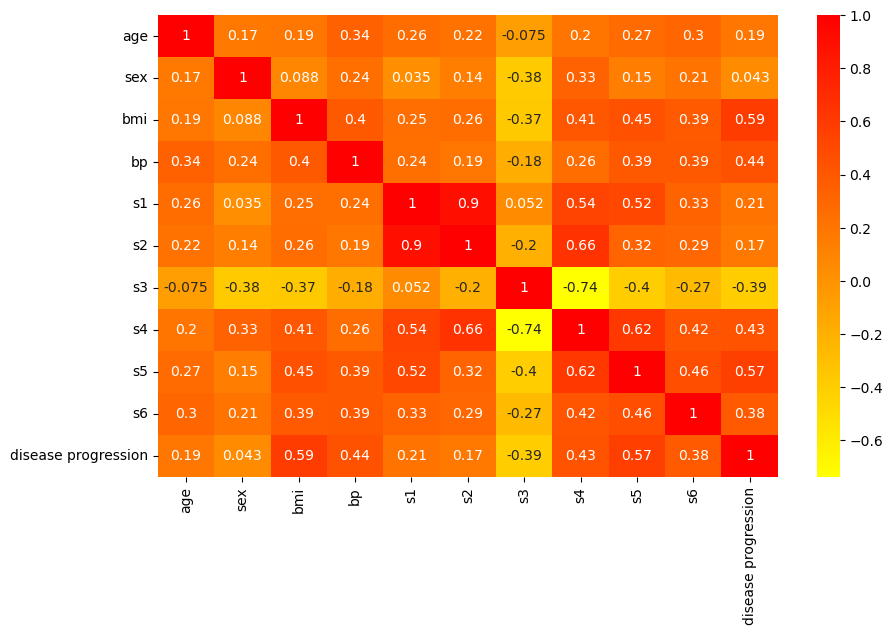

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_mat, annot=True, cmap=plt.cm.autumn_r)
plt.show()

#### Detect correlated features in an automated way

In [5]:
# drop the target class when performing correlation. 
# We are interested only in correlation amongst independent features
df_train = df.drop(columns=['disease progression'])

In [28]:
corr_matrix = df_train.corr()

In [193]:
def correlated_features(corr_matrix, thres):
    '''Detect correlated features given a threshold
    '''
    above_thres = {}
    # loop over rows and columns of coor_matrix
    for x in range(corr_matrix.shape[0]):
        for y in range(corr_matrix.shape[1]):
            # get column names
            matrix_cols = corr_matrix.columns
            # access each value of the corr_matrix in [i,j] position
            value = corr_matrix.values[x,y]
            # apply threshold. We do not want those features with value of 1.
            # these are features that compared to themselves
            if value > thres and value < 1:
                col_name = matrix_cols[x]
                above_thres[matrix_cols[x]] = value
    return above_thres

def unique_correlated_features(dictionary):
    '''Given a dictionary of correlated features in pairs, 
       choose one of those features to be dropped
    '''
    unique_values = {}
    for label, value in dictionary.items():
        if value not in unique_values.values():
            unique_values[label] = value
    unique_list = list(unique_values.keys())
    return unique_list

In [194]:
corr_feats = correlated_features(corr_matrix, 0.7)
corr_feats

{'s1': 0.8966629578104894, 's2': 0.8966629578104894}

In [195]:
unique_feats = unique_correlated_features(corr_feats)
unique_feats

['s1']

We have chosen to discard features based on a threshold value. This value is 0.7. Hence, any pair of features that thier correlation value is above 0.7 are detected. We can see that the results of  the `correlated_features` function detected two features: `s1` and `s2`. This is the only pair of featrues with a value above 0.7. The next step is to decide which one to keep (either is fine). RUnning the function `unique_correlated_features` keeps only the unique correlated features

Below we see the clean dataframe where the correlated feature `s1` is removed

In [196]:
df_clean = df_train.drop(columns=unique_feats)
df_clean

,age,sex,bmi,bp,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.015283,-0.028674,0.026560,0.044529,-0.025930


### Mutual information

It estimates mutual information for a continuous target variable. Mutual information (MI) of two random variables is a measure of the mutual dependence between the two variables. It quantifies the "amount of information" obtained about one random variable by observing the other random variable. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. 

In [5]:
X = df.drop(columns=['disease progression'])
Y = df[['disease progression']]

In [8]:
mutual_info = feature_selection.mutual_info_regression(X, Y)

/home/io/miniconda3/envs/geo/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
df_mutual_info = pd.DataFrame(mutual_info, columns=['values'])
df_mutual_info.index = X.columns
df_mutual_info = df_mutual_info.sort_values(by='values', ascending=False)

In [36]:
df_mutual_info

,values
bmi,0.169451
s5,0.149255
s6,0.120689
s4,0.100205
s1,0.073486
s3,0.073134
bp,0.063316
sex,0.029431
s2,0.011357
age,0.000443


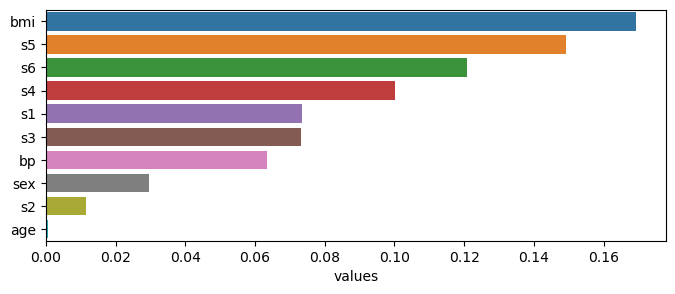

In [41]:
fig, ax = plt.subplots(1, figsize=(8,3))
sns.barplot(data=df_mutual_info, x=df_mutual_info['values'], y=df_mutual_info.index);

from the plot above we can see the first 4 features have the highest correlation with the target variable. This means that those features can contributes the most when doing regression analysis.

#### Select best features based on the percentile

Using perceniles, we can specify the percentile where we want our the data to fall into. For instance, if the perentile is set to be 20, then only the 20% highet score features will be selected. As an alternative, [selectKbest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) can be used. The difference is that in selectKbest the user need to specify the number of best features to be kept compared to percentile where the user specifies the percentile and ay features that fall beyond this threshold they are rejected.  

In [83]:
select_percentile = feature_selection.SelectPercentile(feature_selection.mutual_info_regression, percentile=20)
select_percentile.fit_transform(X, Y.iloc[:,0]);

In [85]:
best_feats = X.columns[select_percentile.get_support()]
best_feats

Index(['bmi', 's5'], dtype='object')

In [89]:
df_best_feats = X[best_feats]
df_best_feats.head()

,bmi,s5
0,0.061696,0.019907
1,-0.051474,-0.068332
2,0.044451,0.002861
3,-0.011595,0.022688
4,-0.036385,-0.031988


## Variance
Feature selector that removes all low-variance features. This feature selection algorithm looks only at the features (X), not the desired outputs (y), and can thus be used for unsupervised learning.

In [144]:
# drop the target class. We are interested only in the independent features
df_train = df.drop(columns=['disease progression'])

In [145]:
var = feature_selection.VarianceThreshold(threshold=0.0)
var.fit(df_train)

VarianceThreshold()

In [146]:
var.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

As we can see, the results from `var.get_support()` produce an array of True elements. This indicates that there are no feaures of low variance in our dataset. Hence, no columns are being dropped. This is becasue, our dataset is so small where it is unlikely that there will be features of zero valiance

Below, we will examine a different dataset with many more features and see how varaince can be used to discard features with zero variance

### Load larger dataset

customer satisfaction dataset by [Kaggle](https://www.kaggle.com/c/santander-customer-satisfaction/data?select=train.csv)

In [222]:
path = 'raw/santander-customer-satisfaction/train.csv'
df = pd.read_csv(path, nrows=5000)

In [223]:
df_train = df.drop(columns=['TARGET'])

In [224]:
var = feature_selection.VarianceThreshold(threshold=0.0)
var.fit(df_train)

VarianceThreshold()

In [225]:
high_var = sum(var.get_support())
low_var = df_train.shape[1] - sum(var.get_support())

print (f"zero var: {low_var} features   Higher_var: {high_var} features")

zero var: 91 features   Higher_var: 279 features


In [226]:
# get only those features with zero variance
var_support = var.get_support()
low_var_cols = [col for col in df_train.columns
                if col not in df_train.columns[var_support]]

In [227]:
# display only the first five of zero variance
low_var_cols[:5]

['ind_var2_0',
 'ind_var2',
 'ind_var13_medio_0',
 'ind_var13_medio',
 'ind_var18_0']

In [232]:
# calcualte some simple statistics
mean_arr = []
var_arr = []
std_arr = []
feat_arr = []
for k,v in df_train.items():
    mean = np.abs(np.round(np.mean(df[k]),1))
    var = np.round(np.var(df[k]),5)
    std = np.round(np.std(df[k]),5)
    mean_arr.append(mean)
    var_arr.append(var)
    std_arr.append(std)
    feat_arr.append(k)

In [233]:
# create  a dataframe and store the statistics
feats = {'feat name':feat_arr, 'mean':mean_arr, 'variance':var_arr, 'std':std_arr}
var_df = pd.DataFrame(data=feats)

In [234]:
var_df.loc[var_df['variance']==0]

,feat name,mean,variance,std
22,ind_var2_0,0.0,0.0,0.0
23,ind_var2,0.0,0.0,0.0
37,ind_var13_medio_0,0.0,0.0,0.0
38,ind_var13_medio,0.0,0.0,0.0
44,ind_var18_0,0.0,0.0,0.0
...,...,...,...,...
351,saldo_medio_var13_medio_ult1,0.0,0.0,0.0
352,saldo_medio_var13_medio_ult3,0.0,0.0,0.0
354,saldo_medio_var17_hace3,0.0,0.0,0.0
357,saldo_medio_var29_hace2,0.0,0.0,0.0


For this dataset, we managed to detect 91 features with zero varaince. If we need to build a machine learning model, those features will not contribute much. Hence, we can discard them

In [248]:
clean_df = df_train.drop(columns=low_var_cols)
clean_df

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,1,2,23,0.0,0.00,0.00,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000
1,3,2,34,0.0,0.00,0.00,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000
2,4,2,23,0.0,0.00,0.00,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000
3,8,2,37,0.0,195.00,195.00,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000
4,10,2,39,0.0,0.00,0.00,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,9978,2,27,0.0,0.00,0.00,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62115.120000
4996,9979,2,37,0.0,0.00,0.00,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
4997,9981,2,23,0.0,0.00,0.00,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103187.190000
4998,9985,2,25,0.0,0.00,0.00,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32709.960000
